# PYMC4 & Bambi
This analysis uses a 5 year data set I previously created. The main objective of this notebook is to figure out how to get an interesting model, that runs in a reasonable amount of time.

**Data Splitting**
+ 2017-2019 use to inform priors (how?)
+ 2020 training
+ 2021 holdout

## Quick Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import bambi as bmb

import aesara.tensor as at

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('joined_crash_2017+2021.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482367 entries, 0 to 482366
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   X                        482367 non-null  float64
 1   Y                        482367 non-null  float64
 2   OBJECTID                 482367 non-null  int64  
 3   DOCUMENT_NBR             482367 non-null  int64  
 4   CRASH_YEAR               482367 non-null  int64  
 5   CRASH_SEVERITY           482367 non-null  object 
 6   CRASH_DT                 482367 non-null  object 
 7   WEATHER_CONDITION        482367 non-null  object 
 8   LIGHT_CONDITION          482367 non-null  object 
 9   RD_TYPE                  482367 non-null  object 
 10  ROADWAY_ALIGNMENT        482367 non-null  object 
 11  ROADWAY_SURFACE_TYPE     482367 non-null  object 
 12  ROADWAY_DEFECT           482367 non-null  object 
 13  ROADWAY_DESCRIPTION      482367 non-null  object 
 14  TRFC

In [3]:
# correcting dtypes
type_dict = {c:'category' for c in data.columns if data[c].dtypes=='O'}
type_dict['CRASH_DT'] = 'datetime64'
type_dict['RURALURBANDESC'] = 'category'
type_dict['MEDIAN_TYPE'] = 'category'

data = data.astype(type_dict)

I will cut these columns because (1) they convey redundant information, (2) I don't understand them.

|**drop column**|**reason**|
|----------|----------|
|`RD_TYPE`|Interpretation Unclear|
|`AREA_TYPE`|Redundant with `RURALURBANDESC`|
|`SYSTEM`|Could be interesting, but I need to cut stuff|
|`SPEED_BEFORE`|behavior variable, not environmental variable|
|`SPEED_MAX_SAFE`|Redundant with `SPEED_POSTED` and environmental variables|
|`PAVEMENT_ROUGHNESSVALUE`|Interpretation Unclear/High Nullness|
|`MEDIAN_TYPE`|Redundant with `ROADWAY_DESCRIPTION`|


In [5]:
# drop columns above
data = data.drop(['RD_TYPE', 'AREA_TYPE', 'SYSTEM',
                  'SPEED_BEFORE', 'SPEED_MAX_SAFE',
                  'PAVEMENT_ROUGHNESSVALUE',
                  'MEDIAN_TYPE'], axis=1)

# lower col names
data.columns = data.columns.str.lower()

In [6]:
for c in data.columns:
    if data[c].dtype.name=='category':
        print(f"\n\t{c}")
        print(data[c].value_counts())


	crash_severity
O    322249
B     95455
C     37901
A     23585
K      3177
Name: crash_severity, dtype: int64

	weather_condition
1. No Adverse Condition (Clear/Cloudy)    398302
5. Rain                                    65774
6. Snow                                     6695
4. Mist                                     6531
3. Fog                                      2265
7. Sleet/Hail                               1741
9. Other                                     649
11. Severe Crosswinds                        243
10. Blowing Sand, Soil, Dirt, or Snow        154
8. Smoke/Dust                                 13
Name: weather_condition, dtype: int64

	light_condition
2. Daylight                            316350
5. Darkness - Road Not Lighted          72373
4. Darkness - Road Lighted              64174
3. Dusk                                 14305
1. Dawn                                 13090
6. Darkness - Unknown Road Lighting      1209
7. Unknown                                866


Next, I will flatten the levels of some categoricals.

|**flattened column**|**strategy**|
|--------------------|------------|
|`trfc_ctrl_status_type`|1. Yes 2. Yes - inhibited 3. No|
|`work_zone_location`|1. Yes 2. No|

Other ideas:  
+ Weather: Clear, Precip, Low Vis, Wind  
+ Light: Daylight, Dark, Low Sun
+ roadway_description: Two-Way, One-Way, Unknown

In [7]:
data['trfc_ctrl_status_type'] = data['trfc_ctrl_status_type'].map({'1. Yes - Working':'1. Yes', 
                                   '6. No Traffic Control Device Present':'3. No', 
                                   '3. Yes - Not Working':'2. Yes - inhibited', 
                                   '2. Yes - Working and Obscured':'2. Yes - inhibited', 
                                   '4. Yes - Not Working and Obscured':'2. Yes - inhibited', 
                                   '5. Yes - Missing':'2. Yes - inhibited'}).astype('category')

data['work_zone_location'] = data['work_zone_location'].map({'5. Not Work Area':'2. No', 
                                                             '3. Activity Area':'1. Yes', 
                                                             '4. Termination Area':'1. Yes', 
                                                             '1. Advance Warning Area':'1. Yes', 
                                                             '2. Transition Area':'1. Yes'}).astype('category')

In [8]:
# trim category levels
# Ex: "5. Rain" is trimmed to "5"

cat_cols = [c for c in data.columns if data[c].dtype.name=='category']

for c in cat_cols:
    data[c] = data[c].astype('str').str[:1].astype('category')
        

In [10]:
# scale numerics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data[['speed_posted', 'numberoflane']] = scaler.fit_transform(data[['speed_posted', 'numberoflane']])

I separate the data by years.

In [118]:
prior_data = data.loc[data.crash_year.isin([2017, 2018, 2019])]
train = data.loc[data.crash_year==2020]
holdout = data.loc[data.crash_year==2021]

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85651 entries, 313977 to 399627
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   x                       85651 non-null  float64       
 1   y                       85651 non-null  float64       
 2   objectid                85651 non-null  int64         
 3   document_nbr            85651 non-null  int64         
 4   crash_year              85651 non-null  int64         
 5   crash_severity          85651 non-null  category      
 6   crash_dt                85651 non-null  datetime64[ns]
 7   weather_condition       85651 non-null  category      
 8   light_condition         85651 non-null  category      
 9   roadway_alignment       85651 non-null  category      
 10  roadway_surface_type    85651 non-null  category      
 11  roadway_defect          85651 non-null  category      
 12  roadway_description     85651 non-null  

---

I further reduce the number of observations for quick testing.

In [120]:
# take a 3% stratified sample of 2020 data
# roughly 2500 observation

from sklearn.model_selection import train_test_split
trainx, _, trainy, _ = train_test_split(train.drop('crash_severity', axis=1), train['crash_severity'],
                                      stratify = train['crash_severity'], train_size = 0.03)

train = trainx.merge(trainy ,left_index=True, right_index=True)
train

,x,y,objectid,document_nbr,crash_year,crash_dt,weather_condition,light_condition,roadway_alignment,roadway_surface_type,roadway_defect,roadway_description,trfc_ctrl_status_type,work_zone_location,intersection_analysis,speed_posted,direction_of_travel_cd,ruralurbandesc,numberoflane,crash_severity
375210,-77.346785,38.669076,717161,210055224,2020,2020-12-25 17:00:00,1,5,1,2,1,1,1,2,V,-0.030540,E,4,0.608857,O
368089,-82.148847,36.629164,708474,203645088,2020,2020-12-26 17:00:00,1,2,1,2,1,2,1,2,U,-0.425985,E,3,0.608857,O
360386,-77.340532,38.602088,698923,203185149,2020,2020-11-10 17:00:00,1,4,1,2,1,3,1,2,V,-0.030540,S,1,-0.875810,O
373572,-76.158857,36.838897,715171,202365079,2020,2020-08-20 17:00:00,1,2,1,2,1,3,1,2,V,1.155795,E,1,0.608857,O
383720,-79.532862,37.323222,727668,200745095,2020,2020-03-10 17:00:00,1,1,4,2,1,1,1,2,N,-0.821430,S,4,1.351190,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352895,-78.462564,38.061116,689634,202045039,2020,2020-07-21 17:00:00,1,5,4,2,1,3,1,2,N,-0.821430,N,4,0.608857,O
356310,-78.494518,38.058166,693923,201805053,2020,2020-06-27 17:00:00,1,4,1,2,1,3,1,2,U,-0.030540,N,2,0.608857,C
381855,-76.104211,36.794457,725355,203365138,2020,2020-11-30 17:00:00,1,2,1,2,1,3,1,2,U,1.946686,N,1,-0.875810,B
375012,-77.063372,38.789846,716928,203125285,2020,2020-11-07 17:00:00,1,4,1,2,1,2,1,2,V,-1.216876,W,4,-0.133477,O


## PYMC model
+ This model uses two (scaled) numeric predictors
    + `speed_posted` & `numberoflane`

In [14]:
X = train[['speed_posted', 'numberoflane']]
zX = X.values

In [15]:
# Number of categories
n_cat = train.crash_severity.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pm.Model() as model_softmax:
    # priors for categories 2-4, excluding reference category 1 which is set to zero below.
    zbeta0_ = pm.Normal('zbeta0_', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta_ = pm.Normal('zbeta_', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    # add prior values zero (intercept, predictors) for reference category 1.
    zbeta0 = pm.Deterministic('zbeta0', at.concatenate([[0], zbeta0_]))
    zbeta = pm.Deterministic('zbeta', at.concatenate([at.zeros((zX_dim, 1)), zbeta_], axis=1))

    mu = zbeta0 + pm.math.dot(zX, zbeta)
    
    # Theano softmax function
    p = pm.Deterministic('p', at.nnet.softmax(mu))
    
    y = pm.Categorical('y', p=p, observed=train.crash_severity.cat.codes.values)
    trace = pm.sample(2000, return_inferencedata=True)


C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0_, zbeta_]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


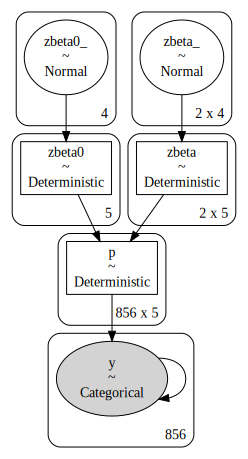

In [16]:
pm.model_to_graphviz(model_softmax)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


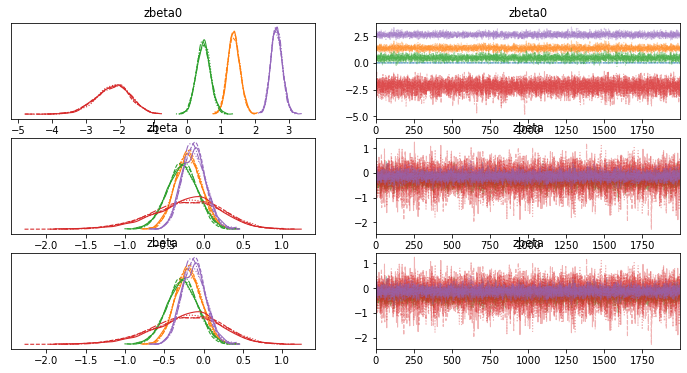

In [17]:
with model_softmax:
    pm.plot_trace(trace, ['zbeta0', 'zbeta', 'zbeta'], coords={'zbeta0_dim_0':list(np.arange(5)),
                                                     'zbeta_dim_0':[0],
                                                     'zbeta_dim_1':list(np.arange(5)),
                                                     'zbeta_dim_0':[1]})

In [18]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Trying  adding categorical predictor:

In [136]:
# OHE categoricals
enc_features = pd.get_dummies(train.iloc[:,6:-1], drop_first=True)
enc_features.columns

Index(['speed_posted', 'numberoflane', 'weather_condition_3',
       'weather_condition_4', 'weather_condition_5', 'weather_condition_6',
       'weather_condition_7', 'weather_condition_8', 'weather_condition_9',
       'light_condition_2', 'light_condition_3', 'light_condition_4',
       'light_condition_5', 'light_condition_6', 'light_condition_7',
       'roadway_alignment_2', 'roadway_alignment_3', 'roadway_alignment_4',
       'roadway_alignment_5', 'roadway_alignment_6', 'roadway_alignment_7',
       'roadway_alignment_8', 'roadway_alignment_9', 'roadway_surface_type_2',
       'roadway_surface_type_3', 'roadway_surface_type_4',
       'roadway_surface_type_5', 'roadway_surface_type_6', 'roadway_defect_2',
       'roadway_defect_3', 'roadway_defect_4', 'roadway_defect_5',
       'roadway_defect_6', 'roadway_defect_7', 'roadway_defect_8',
       'roadway_defect_9', 'roadway_description_2', 'roadway_description_3',
       'roadway_description_4', 'roadway_description_5',
       't

In [137]:
X = enc_features[['speed_posted', 'light_condition_2', 'light_condition_3', 'light_condition_4',
       'light_condition_5', 'light_condition_6', 'light_condition_7']]
zX = X.values

In [236]:
# Number of categories
n_cat = train.crash_severity.cat.categories.size
# Number of dimensions for X
zSpeed = X['speed_posted'].values
zSpeed = np.expand_dims(zSpeed, axis=1)
zLight = X.drop('speed_posted', axis=1).values

speed_dim =zSpeed.shape[1]
light_dim = zLight.shape[1]

with pm.Model() as model_softmax:
    # priors for categories 2-4, excluding reference category 1 which is set to zero below.
    zbeta0_ = pm.Normal('zbeta0_', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta1_ = pm.Normal('zbeta1_', mu=0, tau=1/20**2, shape=(speed_dim, n_cat-1))
    zbeta2_ = pm.Normal('zbeta2_', mu=0, tau=1/20**2, shape=(light_dim, n_cat-1))
    
    # add prior values zero (intercept, predictors) for reference category 1.
    zbeta0 = pm.Deterministic('zbeta0', at.concatenate([[0], zbeta0_]))
    zbeta1 = pm.Deterministic('zbeta1', at.concatenate([at.zeros((speed_dim, 1)), zbeta1_], axis=1))
    zbeta2 = pm.Deterministic('zbeta2', at.concatenate([at.zeros((light_dim, 1)), zbeta2_], axis=1))

    mu = zbeta0 + pm.math.dot(zSpeed, zbeta1) + pm.math.dot(zLight, zbeta2)
    
    # aesara softmax function
    p = pm.Deterministic('p',at.nnet.softmax(mu))
    
    y = pm.Categorical('y', p=p, observed=train.crash_severity.cat.codes.values)
    trace = pm.sample(2000, tune=2500, target_accept=0.95, cores=1)


C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zbeta0_, zbeta1_, zbeta2_]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 1731 seconds.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1208 divergences after tuning. Increase `target_accept` or reparameterize.


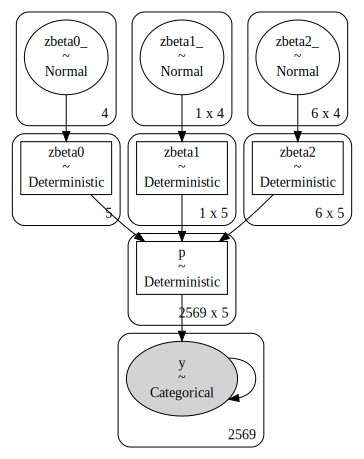

In [237]:
pm.model_to_graphviz(model_softmax)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\arviz\stats\density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'zbeta0'}>,
        <AxesSubplot:title={'center':'zbeta0'}>],
       [<AxesSubplot:title={'center':'zbeta1'}>,
        <AxesSubplot:title={'center':'zbeta1'}>],
       [<AxesSubplot:title={'center':'zbeta2'}>,
        <AxesSubplot:title={'center':'zbeta2'}>]], dtype=object)

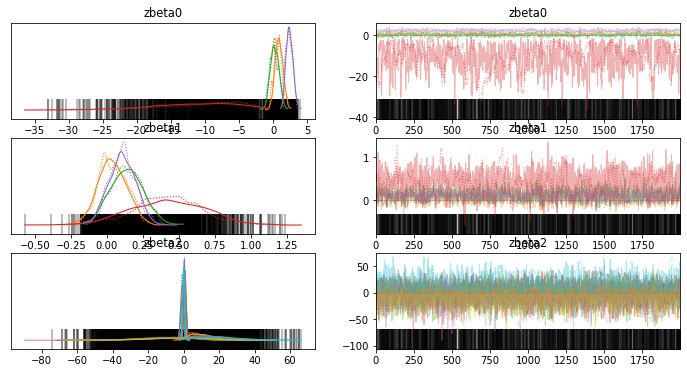

In [241]:
pm.plot_trace(trace, ['zbeta0', 'zbeta1', 'zbeta2'])

In [242]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Model with Bambi

In [243]:
trainc = train[['crash_severity', 'speed_posted', 'light_condition']]
# trainc = pd.get_dummies(trainc, columns = ['crash_severity', 'light_condition'])

In [244]:
trainc.columns

Index(['crash_severity', 'speed_posted', 'light_condition'], dtype='object')

In [245]:
def c(*args):
    return np.column_stack(args)

# function returns sparse encoding

# something like this:
# A -> [0, 1, 0, 0, 0]
# B -> [0, 0, 1, 0, 0]
# O -> [0, 0, 0, 0, 1]

In [246]:


model = bmb.Model("c(crash_severity_A, crash_severity_B, crash_severity_C, crash_severity_K, crash_severity_O) ~ speed_posted + light_condition", 
                  pd.get_dummies(trainc, columns=['crash_severity']), family='multinomial')

fitted = model.fit(draws=2000, tune=2000, random_seed=0, cores=1)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, speed_posted, light_condition]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 2051 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'speed_posted'}>,
        <AxesSubplot:title={'center':'speed_posted'}>],
       [<AxesSubplot:title={'center':'light_condition'}>,
        <AxesSubplot:title={'center':'light_condition'}>]], dtype=object)

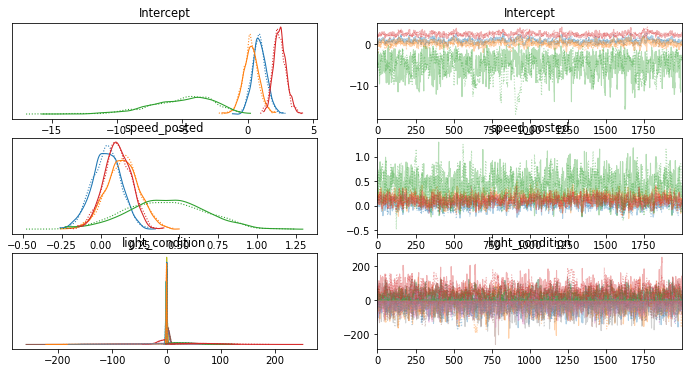

In [247]:
pm.plot_trace(fitted)

In [248]:
pm.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[crash_severity_B],0.897,0.535,-0.163,1.866,0.039,0.027,194.0,311.0,1.01
Intercept[crash_severity_C],0.240,0.605,-0.919,1.370,0.037,0.026,258.0,410.0,1.00
Intercept[crash_severity_K],-5.124,2.521,-9.854,-1.173,0.174,0.136,262.0,290.0,1.01
Intercept[crash_severity_O],2.443,0.488,1.523,3.388,0.036,0.026,184.0,334.0,1.01
speed_posted[crash_severity_B],0.036,0.092,-0.134,0.210,0.005,0.003,377.0,759.0,1.00
speed_posted[crash_severity_C],0.138,0.107,-0.056,0.347,0.005,0.004,407.0,556.0,1.00
speed_posted[crash_severity_K],0.417,0.248,-0.038,0.874,0.010,0.007,583.0,1022.0,1.00
speed_posted[crash_severity_O],0.106,0.087,-0.051,0.275,0.005,0.003,339.0,563.0,1.00
"light_condition[crash_severity_B, 2]",0.510,0.542,-0.474,1.571,0.038,0.027,205.0,325.0,1.00
"light_condition[crash_severity_B, 3]",0.583,0.762,-0.867,2.093,0.056,0.043,191.0,150.0,1.01


In [249]:
from sklearn.preprocessing import LabelBinarizer

def cc(args):

    lb = LabelBinarizer()
    return lb.fit_transform(args).astype('uint8')

# similar to function above
# returns sparse encoding
# allows for neater formulas

In [250]:
model = bmb.Model("cc(crash_severity) ~ speed_posted + light_condition", 
                  train, family='multinomial')

fitted = model.fit(draws=2000, tune=2000, random_seed=0, cores=1)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, speed_posted, light_condition]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1994 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'speed_posted'}>,
        <AxesSubplot:title={'center':'speed_posted'}>],
       [<AxesSubplot:title={'center':'light_condition'}>,
        <AxesSubplot:title={'center':'light_condition'}>]], dtype=object)

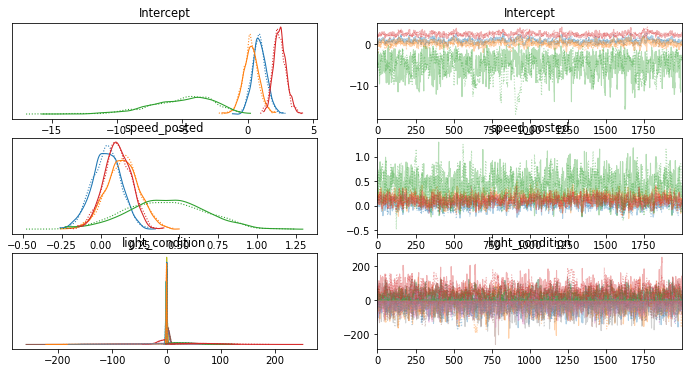

In [251]:
pm.plot_trace(fitted)

In [252]:
pm.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[1],0.897,0.535,-0.163,1.866,0.039,0.027,194.0,311.0,1.01
Intercept[2],0.240,0.605,-0.919,1.370,0.037,0.026,258.0,410.0,1.00
Intercept[3],-5.124,2.521,-9.854,-1.173,0.174,0.136,262.0,290.0,1.01
Intercept[4],2.443,0.488,1.523,3.388,0.036,0.026,184.0,334.0,1.01
speed_posted[1],0.036,0.092,-0.134,0.210,0.005,0.003,377.0,759.0,1.00
speed_posted[2],0.138,0.107,-0.056,0.347,0.005,0.004,407.0,556.0,1.00
speed_posted[3],0.417,0.248,-0.038,0.874,0.010,0.007,583.0,1022.0,1.00
speed_posted[4],0.106,0.087,-0.051,0.275,0.005,0.003,339.0,563.0,1.00
"light_condition[1, 2]",0.510,0.542,-0.474,1.571,0.038,0.027,205.0,325.0,1.00
"light_condition[1, 3]",0.583,0.762,-0.867,2.093,0.056,0.043,191.0,150.0,1.01


### Scaling up!

In [121]:
import time

t0 = time.time()

bigmodel = bmb.Model("cc(crash_severity) ~ speed_posted + light_condition + direction_of_travel_cd + roadway_alignment", 
                  train, family='multinomial')

bigtrace = bigmodel.fit(draws=1000, tune=2000, random_seed=0, cores=1)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, speed_posted, light_condition, direction_of_travel_cd, roadway_alignment]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2276 seconds.


In [122]:
print(f"TIME: {time.time()-t0}")

TIME: 2286.4035515785217


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'speed_posted'}>,
        <AxesSubplot:title={'center':'speed_posted'}>],
       [<AxesSubplot:title={'center':'light_condition'}>,
        <AxesSubplot:title={'center':'light_condition'}>],
       [<AxesSubplot:title={'center':'direction_of_travel_cd'}>,
        <AxesSubplot:title={'center':'direction_of_travel_cd'}>],
       [<AxesSubplot:title={'center':'roadway_alignment'}>,
        <AxesSubplot:title={'center':'roadway_alignment'}>]], dtype=object)

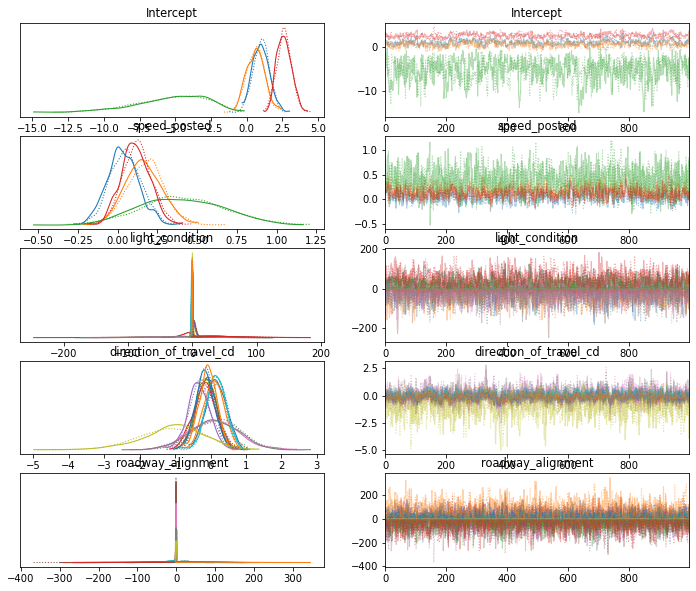

In [123]:
pm.plot_trace(bigtrace)

In [124]:
pm.summary(bigtrace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[1],1.010,0.573,-0.057,2.032,0.037,0.026,239.0,529.0,1.00
Intercept[2],0.629,0.631,-0.649,1.698,0.041,0.029,242.0,463.0,1.00
Intercept[3],-5.318,2.556,-10.314,-1.261,0.129,0.096,438.0,424.0,1.00
Intercept[4],2.631,0.509,1.750,3.634,0.035,0.025,217.0,413.0,1.00
speed_posted[1],0.042,0.100,-0.128,0.249,0.004,0.003,551.0,740.0,1.00
...,...,...,...,...,...,...,...,...,...
"roadway_alignment[4, 5]",-0.280,0.716,-1.564,1.037,0.029,0.020,643.0,762.0,1.00
"roadway_alignment[4, 6]",0.091,1.325,-2.111,2.622,0.051,0.041,771.0,681.0,1.00
"roadway_alignment[4, 7]",27.197,17.201,0.177,57.937,0.899,0.636,389.0,653.0,1.01
"roadway_alignment[4, 8]",49.869,32.145,-4.179,104.722,1.430,1.012,532.0,761.0,1.00


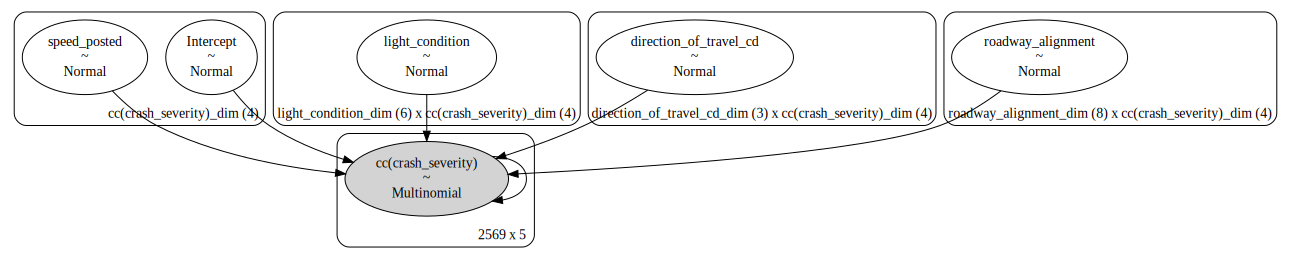

In [126]:
bigmodel.graph()